## Implementation of decision tree for regression task 

Building decision tree is a greedy approach to select the feature space partitioning in a tree. 
Therefore, in this exercise, we hope that you can learn how the decision tree is built.    

In fact, we have adopted the implementation from [Normalized nerd](https://www.youtube.com/@NormalizedNerd). So, feel free to watch the video: [Decision tree for regression](https://www.youtube.com/watch?v=UhY5vPfQIrA), as your reference. 

- [Import tools](#import-tools)
- [Get the data](#get-the-data) 
- [Decision tree implementation](#decision-tree-implementation)
    - [Node class](#node-class)
    - [Decision tree class](#decision-tree-regressor-class)
- [Runing inference](#running-inference)
- [sklearn's decision tree](#sk-learn-decision-treee-regressor)

## Import tools

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler  

## Get the data

In [2]:
foldername           = "Salary"
df_all               = pd.read_csv('%s/Salary_Data.csv' % foldername)   
input_feature_column = [ 'Age', 'Years of Experience']
target_column        = [ 'Salary']
df                   = df_all[input_feature_column + target_column].copy()

encoded_column       = [ 'Age'  ]   
df[encoded_column]   = df[encoded_column]
df[encoded_column]   = df[encoded_column].apply(LabelEncoder().fit_transform)

df                   = df.dropna() 
df                   = df.reset_index(drop=True)  

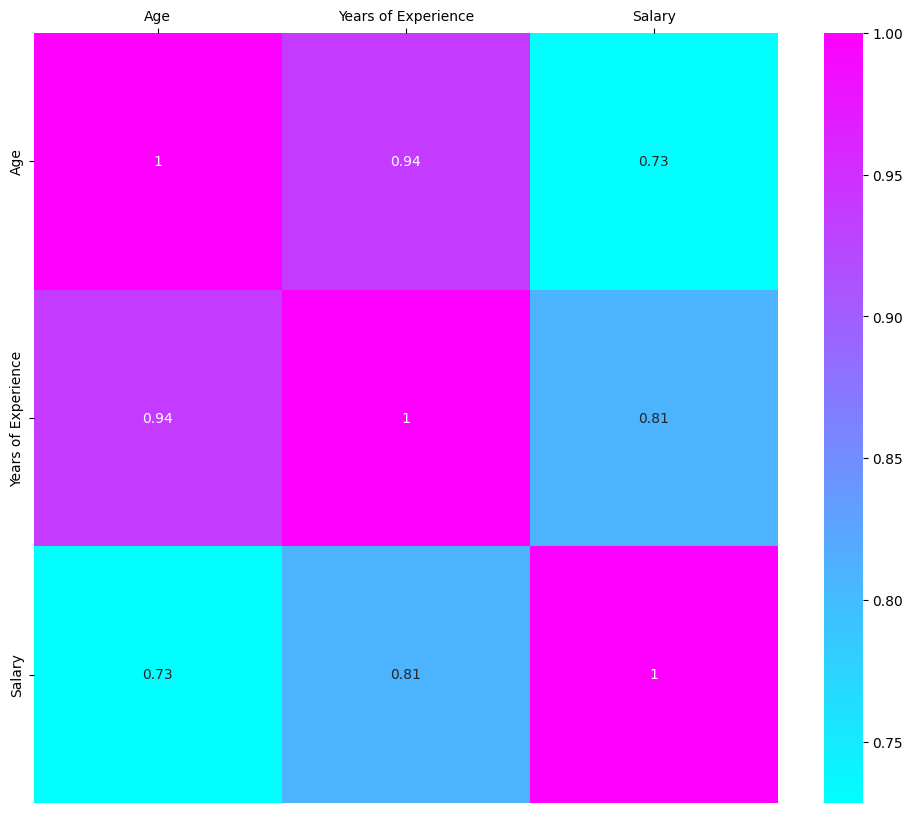

In [3]:
from sklearn import metrics  
import seaborn as sns
import matplotlib.pyplot as plt  

plt.figure(figsize=(12,10))
cor = df.corr()
g = sns.heatmap(cor, annot=True, cmap=plt.cm.cool) 
g.axes.xaxis.set_ticks_position("top")
plt.setp(g.axes.get_xticklabels(), rotation=0)
plt.show()

## Decision tree implementation

### Node class

In [4]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

### Decision tree regressor class

In [5]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left  = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, left_child, right_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(left_child) / len(parent)
        weight_r = len(right_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(left_child) + weight_r * np.var(right_child))
        return reduction
    
    def calculate_leaf_value(self, y_train):
        ''' function to compute leaf node '''
        
        val = np.mean(y_train)
        return val 

    def fit(self, X_train, Y_train):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X_train, Y_train), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x_test, root):
        ''' function to predict new dataset '''
        
        if root.value!=None: return root.value
        feature_val = x_test[root.feature_index]
        if feature_val<=root.threshold:
            return self.make_prediction(x_test, root.left)
        else:
            return self.make_prediction(x_test, root.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    

## Train-Test split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

## Running inference

In [8]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(X_train,Y_train)
Y_pred = regressor.predict(X_test)

In [9]:
np.sqrt(mean_squared_error(Y_test, Y_pred))

np.float64(25048.921292475094)

## SK learn decision treee regressor

In [10]:
from sklearn.tree import DecisionTreeRegressor

Sk_regressor = DecisionTreeRegressor(max_depth=3)

Sk_regressor.fit(X_train ,Y_train)

DecisionTreeRegressor(max_depth=3)

In [11]:
Y_test_predict = Sk_regressor.predict(X_test)

In [12]:
np.sqrt(mean_squared_error(Y_test, Y_test_predict))

np.float64(27092.156448431102)